In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA

def shared_neighbor_label(ad, label_obs_idx):
    sc.pp.neighbors(ad, n_neighbors=101, use_rep='projection') # 100 nearest neighbor of each cell
    m_ATAC_neighbors = [i.indices for i in ad.obsp['distances']] # neighbor idx for each cell
    neighbor_label = ad.obs.iloc[np.concatenate(m_ATAC_neighbors, axis=0), label_obs_idx] # label for all neighbors
    cell_label = ad.obs.iloc[np.repeat(np.arange(len(m_ATAC_neighbors)), [len(j) for j in m_ATAC_neighbors]), label_obs_idx] # label for all cells
    n_shared = (neighbor_label.values==cell_label.values).sum() / len(m_ATAC_neighbors)
    return n_shared

ad = anndata.read_h5ad('/home/yuanh/sc_basset/Buenrostro_2018/sc_peakset/raw/ad.h5ad')

In [2]:
z_motif = pd.read_csv('z_motif.csv', index_col=0)
z_kmer = pd.read_csv('z_kmer.csv', index_col=0)
z_motif = z_motif.loc[:,np.sum(z_motif.isna())==0] # exclude columns with 0

In [4]:
pca = PCA(n_components=100)
embed = pca.fit_transform(z_motif)

scores_motif = []
pcs = np.arange(10, 101, 10)
for i in pcs:
    ad.obsm['projection'] = embed[:,:i]
    scores_motif += [shared_neighbor_label(ad, 1)]
    
ad.obsm['projection'] = z_motif.values
scores_motif += [shared_neighbor_label(ad, 1)]

In [5]:
pca = PCA(n_components=100)
embed = pca.fit_transform(z_kmer)

scores_kmer = []
pcs = np.arange(10, 101, 10)
for i in pcs:
    ad.obsm['projection'] = embed[:,:i]
    scores_kmer += [shared_neighbor_label(ad, 1)]
    
ad.obsm['projection'] = z_kmer.values
scores_kmer += [shared_neighbor_label(ad, 1)]

In [7]:
output = pd.DataFrame({'pcs':np.append(pcs.astype('str'), 'all'),
                       'scores_motif':scores_motif,
                       'scores_kmer':scores_kmer})
output.to_csv('shared_neighbor_label.csv')

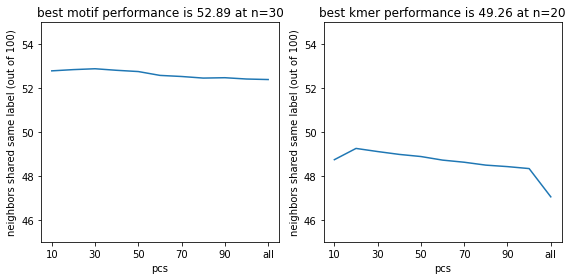

In [18]:
toplot = output.copy()
toplot.set_index('pcs', inplace=True)

f, axs = plt.subplots(figsize=(8, 4), ncols=2)
toplot['scores_motif'].plot.line(ax=axs[0])
toplot['scores_kmer'].plot.line(ax=axs[1])

best_n = pcs[output['scores_motif'].argmax()]
best_val = output['scores_motif'].max()
axs[0].set_ylabel('neighbors shared same label (out of 100)')
axs[0].set_title('best motif performance is %.2f at n=%d'%(best_val, best_n))
axs[0].set_ylim(45, 55)

best_n = pcs[output['scores_kmer'].argmax()]
best_val = output['scores_kmer'].max()
axs[1].set_ylabel('neighbors shared same label (out of 100)')
axs[1].set_title('best kmer performance is %.2f at n=%d'%(best_val, best_n))
axs[1].set_ylim(45, 55)

f.tight_layout()
f.savefig('eval.pdf')

In [20]:
embed = pca.fit_transform(z_motif)
pd.DataFrame(embed[:,:30]).to_csv('projection_motif.csv')

embed = pca.fit_transform(z_kmer)
pd.DataFrame(embed[:,:20]).to_csv('projection_kmer.csv')

### plot tsne

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


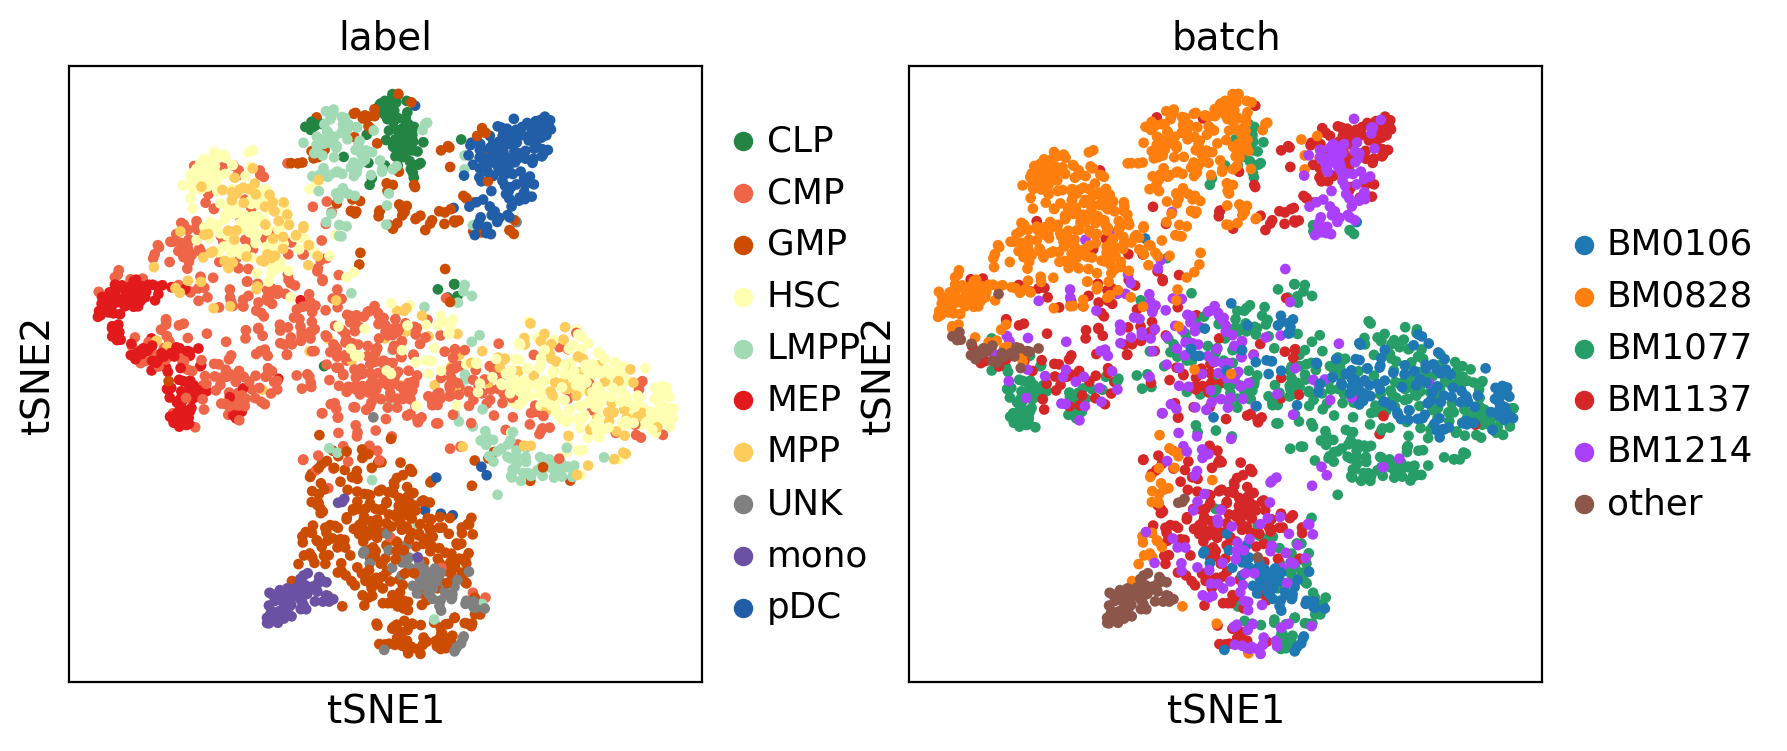

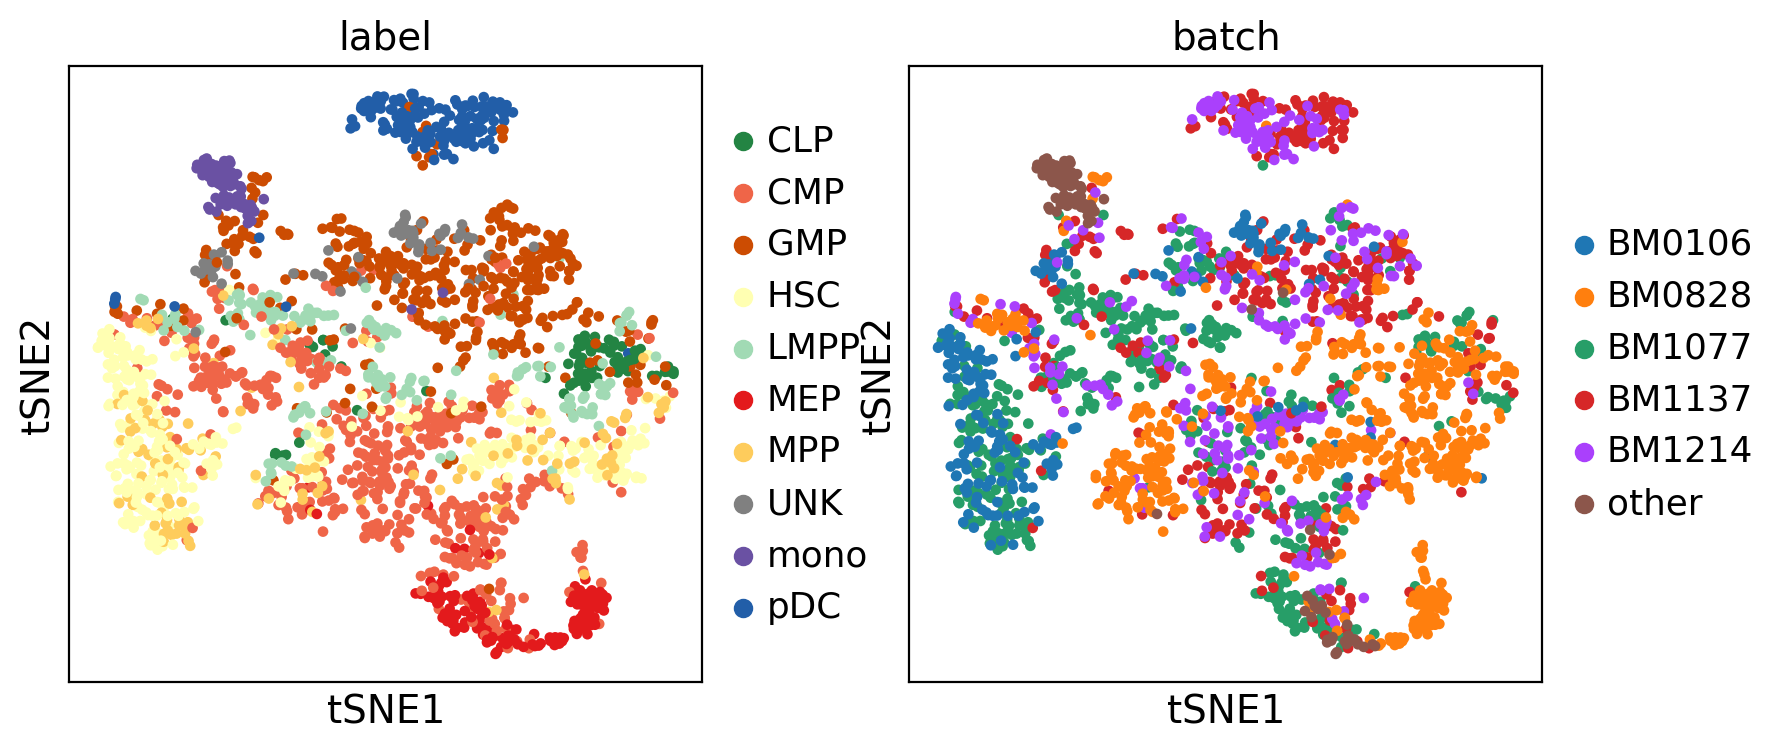

In [2]:
sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad.obsm['projection'] = pd.read_csv('projection_motif.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')
f = sc.pl.tsne(ad, color=['label', 'batch'], return_fig=True)
f.savefig('tsne_label_motif.pdf')

ad.obsm['projection'] = pd.read_csv('projection_kmer.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')
f = sc.pl.tsne(ad, color=['label', 'batch'], return_fig=True)
f.savefig('tsne_label_kmer.pdf')
